*Understanding bagging, random forest, and boosting (gradient boosting and histgradientboosting)*

![](intro_image.webp)


# Understanding bagging, random forest, and boosting

## Introduction

Decision trees are popular because they are very easy to understand and very flexible. The main problem with decision trees is that they suffer from high variance. High variance means that the model is very sensitive to the specific details of the training data. If we split the training data into different subsets and train the model  separately on each subset, the model performance and the results wil vary significantly.
This variability indicates that the model is overfitting to the traning data and not generalizing well to unseen data. This happens because complex models like decision trees have a lot of flexibility and can capture a lot of details in the training data.

More simpler models like linear regression with low variance will give you a similar result on different subsets of the training data. This is because linear regression is not very flexible and cannot capture the details in the training data.

To reduce the variance of a model, we are going to use a technique called ensemble learning. Ensemble learning combine many simple models , called weak learners, to create a more powerful model. 

## Bagging

Bagging stands for bootstrap aggregating and is designed to improve stability and accuracy of machine learning algorithms. 

>Stability in machine learning refers to the model's ability to produce consistent results when the training data changes slightly.

Boostrap is a very powerful statistical tool that can be used to estimate the uncertainty associated with a given estimator or statistical learning method (Introduction to Statistical Learning chapter 5). 

We are going to focus on how we can use boostraps to reduce the variance of a statistical learning method as a decision tree. 

Suppose you have $n$ independent observations $Z_1, Z_2, ..., Z_n$, each with variance $\sigma^2$. The variance of the mean of these observations ($\bar{Z}$) is given by $\sigma^2/n$. This means that averaging a set of observations reduces the variance.

To reduce the variance of a prediction model, you can train multiple models on diferent training set and average their predictions. So having access to multiple training sets, you could build $B$ separate models $f_1(x), f_2(x), ..., f_B(x)$ and average their predictions to obtain a final model with lower variance than the individual models 
$$\hat{f}_{avg}(x) = \frac{1}{B} \sum_{b=1}^{B} f_b(x)$$

In reality, you don't have access to multiple training sets, but you can simulate this by boostrapping the training data. Boostrapping is a resampling technique that samples with replacement from the training data to create multiple training sets. This procedure allows you to generate B different bootstrapped training sets. 
$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B} f_{*b}(x)$$

As bagging method provide a way to reduce overfitting, bagging methods works best with strong and complex models like fully developed decision trees in contrast to boosting methods that works best with weak models like shallow decision trees. The reason behind this is that deep trees has high variance, but low bias. Bagging can reduce the variance of the model, but it does not reduce the bias. 

Bagging methods come in many flavors:
- Pasting -> random subsets of the dataset are drawn as random susets of the samples
- Bagging -> when samples are drawn with replacement.
- Random Subspaces -> when features are drawn as random subsets of the features
- Random Patches -> when samples and features are drawn as random subsets of the samples and features

In [106]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [4]:
results = {}

In [3]:
SEED = 42

In [5]:
# cross-validation function
def cross_val(model, name):
    if name not in results:
        results[name] = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for f, (idx_t, idx_v) in enumerate(skf.split(X, y)):
        X_t = X.iloc[idx_t]
        X_v = X.iloc[idx_v]
        y_t = y.iloc[idx_t]
        y_v = y.iloc[idx_v]

        model.fit(X_t, y_t)
        preds = model.predict(X_v)
        results[name].append(accuracy_score(y_v, preds))
        print(f'Fold {f+1}, Accuracy: {results[name][-1]}')

    
    print(f'Mean Accuracy: {np.mean(results[name])} ± {np.std(results[name])}')

In [6]:
PATH_HEART = '/home/jmanu/git/dsjournal/posts/decision_tree_classification/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(PATH_HEART)

# split the data into features and target
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

In [7]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=SEED)

cross_val(dtc, name='DecisionTree')



Fold 1, Accuracy: 0.75
Fold 2, Accuracy: 0.8333333333333334
Fold 3, Accuracy: 0.7666666666666667
Fold 4, Accuracy: 0.7166666666666667
Fold 5, Accuracy: 0.6949152542372882
Mean Accuracy: 0.7523163841807909 ± 0.047625275580747764


In scikit-learn, all the bagging methods are implemented in the `BaggingClassifier` and `BaggingRegressor` classes.
You can control the size of the subset of the samples and features by using the `max_samples` and `max_features` parameters. `bootstrap` and `bootstrap_features` control if the samples and features are drawn with or without replacement.

When using a subset of samples, generalization can be estimated with the out-of-bag samples. The out-of-bag samples are the samples that are not included in the bootstrap sample. You just need to set the `oob_score` parameter to `True` to get the out-of-bag score.

In [ ]:
for n_est in range(1, 101):
    bagging = BaggingClassifier(estimator=dtc, n_estimators=n_est, random_state=SEED, n_jobs=-1)
    cross_val(bagging, name=f'Bagging_{n_est}')

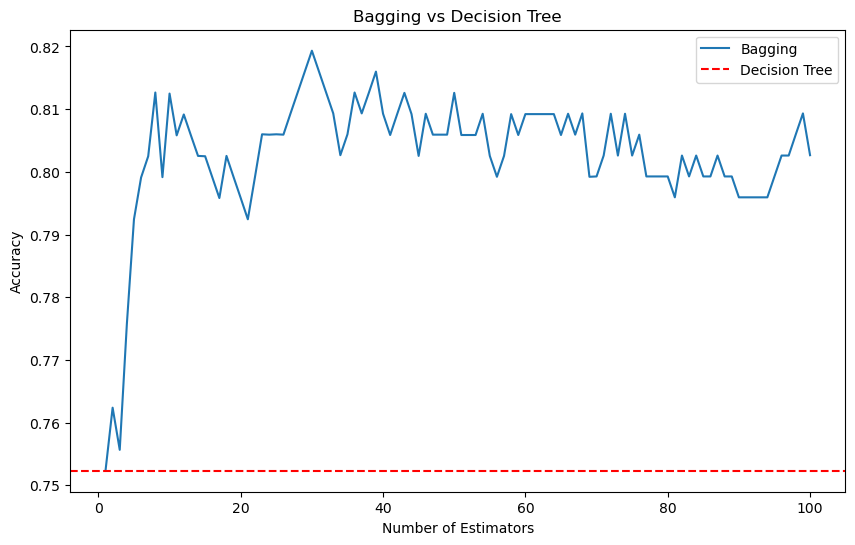

In [31]:
# plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), [np.mean(results[f'Bagging_{n}']) for n in range(1, 101)], label='Bagging')
plt.axhline(np.mean(results['DecisionTree']), color='r', linestyle='--', label='Decision Tree')
plt.title('Bagging vs Decision Tree')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Out-of-bag 

There's a simple way to estimate the test error of a bagged model without the need to do cross-validation.
When you bootstrap a dataset, about 63% of the original dataset is used to train the model and the remaining 37% is left out. This is due to the  nature of the bootstrap sampling. 

As we said, in bagging, we create a multiple datasets by randomly sampling with replacement from the original dataset. Each new dataset is called a bootstrap sample and has the same size as the original dataset. So for a dataset with $N$ observations, each observation has a $\frac{1}{N}$ chance of being selected in each draw. Then, when we sample with replacement, the probability that a specific observation is not chosen in one draw is $1 - \frac{1}{N}$. If we draw multiple times $N$ (since each bootstrap sample has N observations), the probability that a specific observation is not chosen in any of the N draws is $(1 - \frac{1}{N})^N$. This is the probability that a specific observation is left out of the bootstrap sample. 

The exponential function $e^x$ is the inverse of the natural logarithm function $\ln(x)$. Considering the natural logarithm of the probability that a specific observation is left out of the bootstrap sample, we have $\ln((1 - \frac{1}{N})^N) = N \ln(1 - \frac{1}{N})$.

For large $N$, $\frac{1}{N}$ becomes very small. We can use the Taylor series expansion for $\ln(1 - x)$ around $x = 0$:
$$\ln(1 - x) \approx -x \quad \text{for small } x$$

Substitute $x = \frac{1}{N}$:
$$\ln\left(1 - \frac{1}{N}\right) \approx -\frac{1}{N}$$

Now, substitute the approximation into the limit:
$$N \ln\left(1 - \frac{1}{N}\right) \approx N \left(-\frac{1}{N}\right) = -1$$

So, we have:
$$\lim_{N \to \infty} N \ln\left(1 - \frac{1}{N}\right) = -1$$

The next step is to exponentiate the result to relate it to the original exponential form. We know that if $a = \ln(b)$, then $b = e^a$. Here, we want to evaluate:
$$\lim_{N \to \infty} \left(e^{N \ln\left(1 - \frac{1}{N}\right)}\right)$$

Since we have established that:
$$\lim_{N \to \infty} N \ln\left(1 - \frac{1}{N}\right) = -1$$

Exponentiating both sides, we get:
$$\lim_{N \to \infty} e^{N \ln\left(1 - \frac{1}{N}\right)} = e^{-1}$$

Thus:
$$\lim_{N \to \infty} \left(1 - \frac{1}{N}\right)^N = \frac{1}{e}$$





When $N$ is large, the limit of $(1 - \frac{1}{N})^N$ is $1/e$ or about 0.368, which means the probability of an observation not being included in a bootstrap sample is roughly 36.8%. Consequently, about 63.2% of the observations are included in the bootstrap sample.

These unused observations are referred to as out-of-bag (OOB) observations, which can be used to estimate how well the model will perform on unseen data. 

The OOB approach is particularly convenient when performing bagging on large datasets for which cross-validation would be computationally expensive.

In [8]:
bagging = BaggingClassifier(estimator=dtc, n_estimators=100, bootstrap=True, oob_score=True, random_state=SEED, n_jobs=-1)
bagging.fit(X, y)
print(f'OOB Score: {bagging.oob_score_}')

OOB Score: 0.802675585284281


## Random Forest

In bagging, the trees are created using bootstrapped samples. This reduces the variance of the model, but it does not reduce the correlation between the trees. If one or a few predictors (features) are very strong for the response variable, these predictors will be selected in many of the bagged trees. This means that the trees will be correlated and will make similar predictions. By selecting a random subset of predictors at each split, random forest ensure that the trees are less correlated. 

Random forest add this additional layer of randomness to the bagging process to imporve the model's performance. At each split in the tree, instead of considering all $p$ predictors, it randomly selects a subset of $m$ predictors as candidates for the split. The number of predictors to consider at each split is a hyperparameter that you can tune.

In scikit-learn, the `RandomForestClassifier` and `RandomForestRegressor` classes implement the random forest algorithm. Each tree in the ensemble is built from a sample drawn with replacement from the training data. The number of sample to draw is controlled by `max_samples` parameter. The number of features to consider at each split is controlled by the `max_features` parameter. The number of trees in the ensemble is controlled by the `n_estimators` parameter.


### Balancing the bias-variance

A practical rule of thumb that balances the need to introduce enough randomness (to de-correlate the trees) and the need to retain enough predictive power is to set $m = \sqrt{p}$. If $m$ is too small, the trees may become too random and not capture the important structure in the data well enough, leading to high bias. If $m$ is too large, the benefit of introducing randomness diminishes, and the trees may become too similar (correlated), leading to high variance. Empirical evidence suggest that choosing $m = \sqrt{p}$ is a good starting point that provides a good trade-off between bias and variance.

### Most important parameters

The main parameters to tune in a random forest are `n_estimators` and `max_features`. The `n_estimators` parameter controls the number of trees in the forest, the larger the better, but also the longer it will take to compute. Be also aware that it will stop getting significantly better beyond a critical number of trees. 

The larger is the size of the random subsets of features, higher is the correlation between the trees, and lower the reduction of variance. The default value of `max_features` is `1.0` and is the equivalent to bagging.

When the `boostrap` is set to `False`, the strategy use is extra-trees. Unlike random forest, which selects the best split among a random subset of features, extra-trees select a random split among a random subset of features, and generally use the entire original dataset (without bootstrapping). This makes the trees more varied. 

In [107]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1, 
                            oob_score=True, min_samples_split=10, criterion='entropy',
                            max_features='sqrt', max_leaf_nodes=6)
rf.fit(X, y)
print(f'OOB Score: {rf.oob_score_}')

OOB Score: 0.862876254180602


In [110]:
rf_scores = cross_val_score(rf, X, y, cv=10, n_jobs=-1, scoring='accuracy')
print(f'RF Mean Accuracy: {np.mean(rf_scores)} ± {np.std(rf_scores)}')

RF Mean Accuracy: 0.7822988505747126 ± 0.19325814821365508


## Boosting

Boosting is another ensemble method that follow a different approach. Instead of using boostrapping to create multiple trees, boosting builds trees sequentially, where each tree is fit on a modifiec version of the dataset. The idea is to fit a sequence of weak learners, where each learner learns from the mistakes of the previous one. So each tree in the sequence is fit using the residuals of the previous tree. By fitting small trees to the residuals, we slowly improve $\hat{f}$. The way we can control this process is with the parameter $\lambda$ also known as the shrinkage parameter. 
When we fit a tree to the residuals, we multiply the predictions of the tree by $\lambda$ before adding it. This slows down the learning process because the model makes smaller adjustments to the residuals with each iteration. The benefit of slow down the learning process is that reduce the risk of overfitting ensuring that the model gradually improves its performance by fitting the residuals in a controlled manner. 


### Boosting algorithm

The boosting algorithm can be summarized in two main steps:

**Step 1: Initialization**

Initilize the model $\hat{f}(x) = 0$ and set the initial residuals as $r_i = y_i$ for all $i$ in the training set. Basically the model predicts zero for all inputs and the residuals are just the actual targets. 

**Step 2: Iterative Boosting Process**

For $b = 1, 2, ..., B$ we are going to repeat the following steps:
1. Fit a tree $\hat{f}_b$ to the residuals with $d$ splits, which means it will have $d+1$ terminal nodes to the training data using the current residuals as the target variable. This create a tree that tries to predict the residuals. 
2. Update the model by adding a shrunkem version of the newly fitted tree to the model where $\lambda$ is the shrinkage parameter and control the contribution of the new tree to the overall model. 
3. Update the residuals $r_i$ for each training instance $i$ by subtracting the predictions of the new tree multiplied by the shrinkage parameter $r_i = r_i - \lambda \hat{f}_b(x_i)$. This is going to reflect the errors made by the updated model.

**Step 3: Output the boosted model**

After $B$ iterations, the final boosted model is:
$$\hat{f}(x) = \sum_{b=1}^{B} \lambda \hat{f}_b(x)$$


### Main boosting parameters
Unlike bagging and random forest, boosting can overfit the training data if $B$ is too large. However, this overfitting tends to occurs slowly, if at all. Like any other machine learning algorithm, the tunning process must be done by cross-validation, to find a balance where the model performs well on unseen data, avoiding overfitting.

The typical values for the shrinkage parameter $\lambda$ are between 0.01 and 0.001. A smaller value of $\lambda$ means that the model learn slower and requires more trees (a larger $B$) to achieve a good performance. 

As we said, $d$ controls the complexity of each tree in the boosted ensemble. A single split (Stump) often works well. In this case, the boosted model fits an additive model where each term involves only a single variable. More generally, $d$ is referred to as the interaction depth. A tree with $d$ splits can involve up to $d$ variables, allowing the model to capture interactions between variables. Increasing $d$ allows the model to capture more complex interactions between features, but also increases the risk of overfitting. 

### Gradient Boosting and HistGradient boosting

Scikit-learn provides two implementations of gradient-boosted trees for classification problems (also regression): `GradientBoostingClassifier` and `HistGradientBoostingClassifier`.  

The `GradientBoosting` class generalizes the boosting concept to any differentiable loss function. It might be preferable for small datasets, where the approximation introduced by binning in the histogram-based version could lead to less precise split points. 

The `HistGradientBoosting` class is inspired by LightGBM. It can be orders of magnitude faster than the `GradientBoosting` class, especially when dealing with large datasets. The speed advantage comes from binning the input samples into integer-valued bins, which significantly reduces the number of splitting points. 

The binning process transforms the continuous input features into discrete bins. Each continuous features is assigned to one of a fixed number of bins. If we set 256 bins, each feature value will be mapped to an integer between 0 and 255. This reduces the number of possible split points in the tree, instead of considering a split at every unique value of the feature, which speeds up the training process. 

The `HistGradientBoosting` class also can handle missing values and categorical data eliminating the need for preprocessing steps like imputation and one-hot encoding.


In [158]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=300, random_state=SEED, loss='log_loss',
                                max_depth=8, learning_rate=0.1, validation_fraction= 0.2,
                                n_iter_no_change=20, tol=1e-5, subsample=0.8, max_features=0.3, 
                                criterion='friedman_mse')
gb.fit(X, y)
print(f'Loss: {gb.oob_score_}')

Loss: 0.040605289014400504


In [156]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(gb, X, y, cv=10, scoring='accuracy')
print(f'GB Mean Accuracy: {np.mean(cv_scores)} ± {np.std(cv_scores)}')

GB Mean Accuracy: 0.7722988505747127 ± 0.1370531931454142


In [197]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(max_iter=400, random_state=SEED, max_depth=2, 
                                    learning_rate=0.1, early_stopping=True, validation_fraction=0.2, 
                                    n_iter_no_change=25, tol=1e-5, scoring='accuracy', max_features=0.3)
hgb.fit(X, y)
print(f'Accuracy: {np.mean(hgb.validation_score_)}')

Accuracy: 0.820952380952381


In [198]:
hgb_scores = cross_val_score(hgb, X, y, cv=10, scoring='accuracy')
print(f'HGB Mean Accuracy: {np.mean(hgb_scores)} ± {np.std(hgb_scores)}')

HGB Mean Accuracy: 0.785632183908046 ± 0.17704377224738546


# Resourses

- [An Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf)
- [Ensembles: Gradient boosting, random forests, bagging, voting, stacking](https://scikit-learn.org/stable/modules/ensemble.html#)
- [Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)
- [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Guide of parameters tuning in Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters)
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
- [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)
- [Lecture 10 - Decision Trees and Ensemble Methods | Stanford University](https://www.youtube.com/watch?v=wr9gUr-eWdA)
- [Heart Failure Prediction | Kaggle](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data/data)